# An introduction to `relatio` 
**Runtime $\sim$ 5min**

Original paper: ["Text Semantics Capture Political and Economic Narratives"](https://arxiv.org/abs/2108.01720)

----------------------------

This is a short demo of the package `relatio`.  It takes as input a text corpus and outputs a list of narrative statements. The pipeline is unsupervised: the user does not need to specify narratives beforehand. Narrative statements are defined as tuples of semantic roles with a (agent, verb, patient, attribute) structure. 

Here, we present the main wrapper functions to quickly obtain narrative statements from a corpus.

----------------------------

In this tutorial, we work with the Trump Tweet Archive corpus.

----------------------------

In [1]:
from relatio import load_data
srl_res = load_data('trump_tweet_archive', 'srl_res')

/home/germain/Desktop/relatio/.tox/dev/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/germain/Desktop/relatio/.tox/dev/lib/python3.7/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from relatio.utils import load_roles
postproc_roles = load_roles('postproc_roles.json')

In [3]:
from relatio.utils import load_entities
known_entities = load_entities('entities.pkl')

top_known_entities = [e[0] for e in list(known_entities.most_common(100)) if e[0] != '']

In [11]:
from relatio.narrative_models import NarrativeModel

m = NarrativeModel(
    model_type = 'hdbscan', #hdbscan, kmeans, or deterministic
    roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1', 'ARG2'],
    roles_with_known_entities = ['ARG0','ARG1','ARG2'],
    known_entities = top_known_entities,
    assignment_to_known_entities = 'character_matching',
    roles_with_unknown_entities = ['ARG0','ARG1','ARG2'],
    threshold = 0.3
)    
             
m.fit(postproc_roles, progress_bar = True)

Matching known entities (with character matching)...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7952/7952 [00:00<00:00, 13562.97it/s]


Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25162/25162 [00:01<00:00, 14186.01it/s]


Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15228/15228 [00:01<00:00, 14711.68it/s]


Computing phrase embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30050/30050 [00:57<00:00, 523.63it/s]


Dimension reduction via PCA + UMAP...
PCA parameters:
{'n_components': 50, 'svd_solver': 'full'}
UMAP parameters:
{'n_neighbors': 15, 'n_components': 2, 'random_state': 0}
Clustering phrases into clusters...
Clustering parameters chosen:
{'min_cluster_size': [24, 49, 74, 100], 'min_samples': [1, 10, 20], 'cluster_selection_method': ['eom'], 'gen_min_span_tree': True, 'approx_min_span_tree': False, 'prediction_data': True}
Labeling the clusters by the most frequent phrases...


/home/germain/Desktop/relatio/relatio/narrative_models.py:445: RuntimeWarning: Multiple labels for cluster 103- 2 shown: [('administration', 144), ('government', 144)]. First one is picked.
  RuntimeWarning,
/home/germain/Desktop/relatio/relatio/narrative_models.py:445: RuntimeWarning: Multiple labels for cluster 158- 2 shown: [('rescue', 4), ('travel ban', 4)]. First one is picked.
  RuntimeWarning,
/home/germain/Desktop/relatio/relatio/narrative_models.py:445: RuntimeWarning: Multiple labels for cluster 161- 2 shown: [('anger', 8), ('hatred', 8)]. First one is picked.
  RuntimeWarning,
/home/germain/Desktop/relatio/relatio/narrative_models.py:445: RuntimeWarning: Multiple labels for cluster 172- 2 shown: [('christian', 9), ('national anthem', 9)]. First one is picked.
  RuntimeWarning,
/home/germain/Desktop/relatio/relatio/narrative_models.py:445: RuntimeWarning: Multiple labels for cluster 175- 2 shown: [('colorado', 13), ('indiana', 13)]. First one is picked.
  RuntimeWarning,


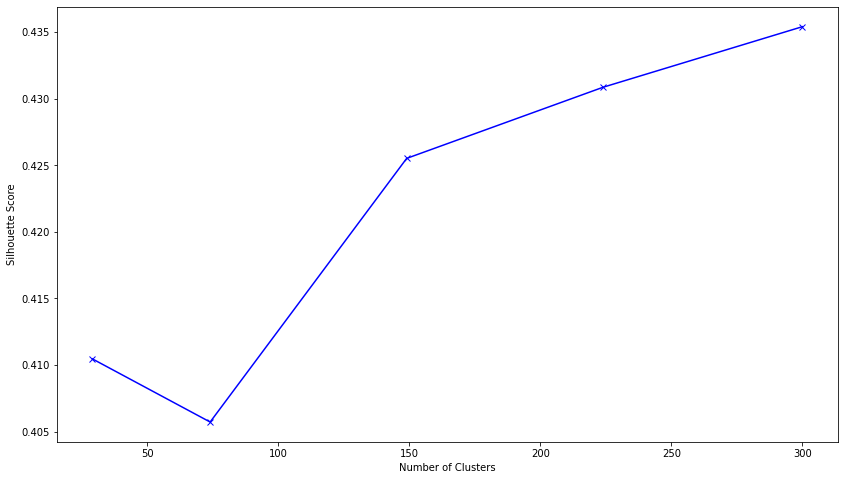

In [5]:
m.plot_selection_metric()

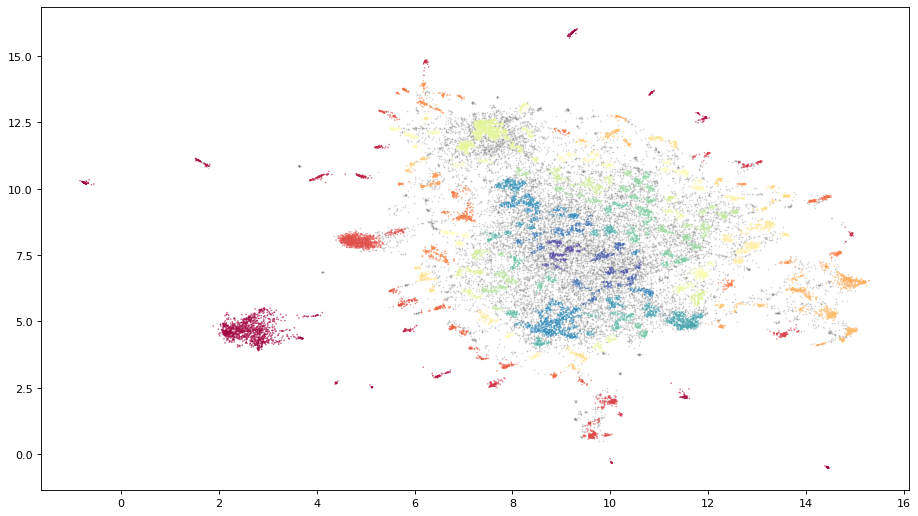

In [12]:
m.plot_clusters('clusters.pdf')

In [7]:
m.labels_unknown_entities

{0: 'foxnew',
 1: 'control',
 2: 'omarosa',
 3: 'lobbyist',
 4: 'crime',
 5: 'work',
 6: 'mess',
 7: 'gold',
 8: 'ventilator',
 9: 'government',
 10: 'rigged election',
 11: 'way',
 12: 'letterman',
 13: 'terrorist',
 14: 'impeachment hoax',
 15: 'corruption',
 16: 'schiff',
 17: 'city',
 18: 'police',
 19: 'oval office',
 20: 'conflict',
 21: 'tariff',
 22: 'amp family',
 23: 'james comey',
 24: 'heart',
 25: 'good',
 26: 'business',
 27: 'loser',
 28: 'interview',
 29: 'russians',
 30: 'immigration',
 31: 'john mccain',
 32: 'time',
 33: 'golf',
 34: 'taxis',
 35: 'warming',
 36: 'twitter',
 37: 'issue',
 38: 'matt',
 39: 'ebola',
 40: 'nfl',
 41: 'joke',
 42: 'family',
 43: 'jeb bush',
 44: 'success',
 45: 'billion dollar',
 46: 'soldier',
 47: 'hoax',
 48: 'debate',
 49: 'poll number',
 50: 'strong',
 51: 'wind turbine',
 52: 'senator',
 53: 'colorado',
 54: 'race',
 55: 'unemployment',
 56: 'dollar',
 57: 'word',
 58: 'haters amp loser',
 59: 'hurricane',
 60: 'company',
 61: 'sou

In [8]:
m.inspect_cluster(label = 'radical left')

[('radical left', 45),
 ('radical', 8),
 ('radical islamic terrorism', 6),
 ('radical islam', 4),
 ('radical left congresswomen', 4),
 ('war radical islamic terrorists', 3),
 ('funding radical ideology', 2),
 ('radical islamic terrorists', 2),
 ('radical left crazy', 2),
 ('radical left crime cancel culture', 2)]

In [9]:
m.clusters_to_txt()

In [10]:
narratives = m.predict(postproc_roles, progress_bar = True)


Predicting entities for role: ARG0...
Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24368/24368 [00:01<00:00, 14595.63it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24368/24368 [00:50<00:00, 485.87it/s]


Dimension reduction of vectors (PCA + UMAP)...
Assignment to clusters...
Assigning labels to matches...

Predicting entities for role: ARG1...
Matching known entities (with character matching)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61012/61012 [00:04<00:00, 14876.83it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


 27%|██████████████████████████████████████████▌                                                                                                                    | 16322/61012 [00:34<01:33, 477.28it/s]


KeyboardInterrupt: 

In [ ]:
from relatio.utils import prettify
from collections import Counter

pretty_narratives = []
for n in narratives: 
    if n.get('ARG0') is not None:
        if n.get('B-V') is not None:
            if n.get('ARG1') is not None:
                pretty_narratives.append(prettify(n))
                
pretty_narratives = Counter(pretty_narratives)
for t in pretty_narratives.most_common(10): print(t)

In [ ]:
from relatio import build_graph, draw_graph

G = build_graph(
    narratives, 
    top_n = 100, 
    prune_network = True
)

draw_graph(
    G,
    notebook = False,
    show_buttons = False,
    width="1600px",
    height="1000px",
    output_filename = 'example.html'
    )